In [1]:
import pandas as pd

In [2]:
orders = pd.read_csv('data.csv',sep=',')

In [3]:
orders

,order_date,order_id,customer,grand_total
0,9/7/11,CA-2011-100006,Dennis Kane,378
1,7/8/11,CA-2011-100090,Ed Braxton,699
2,3/14/11,CA-2011-100293,Neil Franz�sisch,91
3,1/29/11,CA-2011-100328,Jasper Cacioppo,4
4,4/8/11,CA-2011-100363,Jim Mitchum,21
...,...,...,...,...
5004,11/4/14,US-2014-168802,Jack O'Briant,18
5005,7/24/14,US-2014-169320,Lena Hernandez,171
5006,9/8/14,US-2014-169488,Allen Armold,57
5007,8/29/14,US-2014-169502,Matthew Grinstein,113


In [4]:
orders['order_date'] = pd.to_datetime(orders['order_date'])


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5009 entries, 0 to 5008
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   order_date   5009 non-null   datetime64[ns]
 1   order_id     5009 non-null   object        
 2   customer     5009 non-null   object        
 3   grand_total  5009 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 156.7+ KB


In [6]:
orders.isna().sum()

order_date     0
order_id       0
customer       0
grand_total    0
dtype: int64

In [7]:
orders.max()

order_date     2014-12-31 00:00:00
order_id            US-2014-169551
customer        Zuschuss Donatelli
grand_total                  23661
dtype: object

In [8]:
import datetime as dt
NOW = dt.datetime(2014,12,31)

In [9]:
rfmTable = orders.groupby('customer').agg({'order_date': lambda x: (NOW - x.max()).days, # Recency #Количество дней с последнего заказа
                                        'order_id': lambda x: len(x),      # Frequency #Количество заказов
                                        'grand_total': lambda x: x.sum()}) # Monetary Value #Общая сумма по всем заказам

In [10]:
rfmTable


,order_date,order_id,grand_total
customer,,,
Aaron Bergman,415,3,887
Aaron Hawkins,12,7,1744
Aaron Smayling,88,7,3050
Adam Bellavance,54,8,7756
Adam Hart,34,10,3249
...,...,...,...
Xylona Preis,43,11,2375
Yana Sorensen,9,8,6721
Yoseph Carroll,4,5,5455


In [11]:
rfmTable.info()

<class 'pandas.core.frame.DataFrame'>
Index: 793 entries, Aaron Bergman to Zuschuss Donatelli
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   order_date   793 non-null    int64
 1   order_id     793 non-null    int64
 2   grand_total  793 non-null    int64
dtypes: int64(3)
memory usage: 24.8+ KB


In [12]:
rfmTable['order_date'] = rfmTable['order_date'].astype(int)

In [13]:
rfmTable.rename(columns={'order_date': 'recency', 
                         'order_id': 'frequency', 
                         'grand_total': 'monetary_value'}, inplace=True)

In [14]:
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])

In [15]:
quantiles

,recency,frequency,monetary_value
0.25,30.0,5.0,1145.0
0.50,75.0,6.0,2257.0
0.75,183.0,8.0,3784.0


In [16]:
quantiles = quantiles.to_dict()

In [17]:
quantiles

{'recency': {0.25: 30.0, 0.5: 75.0, 0.75: 183.0},
 'frequency': {0.25: 5.0, 0.5: 6.0, 0.75: 8.0},
 'monetary_value': {0.25: 1145.0, 0.5: 2257.0, 0.75: 3784.0}}

In [18]:
rfmSegmentation = rfmTable

In [19]:
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [20]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles,))

rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles,))

rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quantiles,))

In [21]:
rfmSegmentation

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile
customer,,,,,,
Aaron Bergman,415,3,887,4,4,4
Aaron Hawkins,12,7,1744,1,2,3
Aaron Smayling,88,7,3050,3,2,2
Adam Bellavance,54,8,7756,2,2,1
Adam Hart,34,10,3249,2,1,2
...,...,...,...,...,...,...
Xylona Preis,43,11,2375,2,1,2
Yana Sorensen,9,8,6721,1,2,1
Yoseph Carroll,4,5,5455,1,4,1


In [22]:
rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str) \
                            + rfmSegmentation.F_Quartile.map(str) \
                            + rfmSegmentation.M_Quartile.map(str)

In [23]:
rfmSegmentation

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
customer,,,,,,,
Aaron Bergman,415,3,887,4,4,4,444
Aaron Hawkins,12,7,1744,1,2,3,123
Aaron Smayling,88,7,3050,3,2,2,322
Adam Bellavance,54,8,7756,2,2,1,221
Adam Hart,34,10,3249,2,1,2,212
...,...,...,...,...,...,...,...
Xylona Preis,43,11,2375,2,1,2,212
Yana Sorensen,9,8,6721,1,2,1,121
Yoseph Carroll,4,5,5455,1,4,1,141


In [24]:
orders = pd.read_csv('RFM201810.csv',sep=',',low_memory=False)

In [25]:
orders

,InvoiceNo,CustomerCode,InvoiceDate,Amount
0,C0011810010001,19067290,2018-10-01 00:00:00.000,1716.00
1,C0011810010017,13233933,2018-10-01 00:00:00.000,1489.74
2,C0011810010020,99057968,2018-10-01 00:00:00.000,151.47
3,C0011810010021,80007276,2018-10-01 00:00:00.000,146.72
4,C0011810010024,13164076,2018-10-01 00:00:00.000,104.00
...,...,...,...,...
332725,S0081810310459,14092500,2018-10-31 00:00:00.000,3801.87
332726,S0081810310461,99065678,2018-10-31 00:00:00.000,5769.88
332727,S0081810310462,19029918,2018-10-31 00:00:00.000,736.88
332728,S0081810310463,13020033,2018-10-31 00:00:00.000,1475.20


In [26]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332730 entries, 0 to 332729
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   InvoiceNo     332730 non-null  object 
 1   CustomerCode  332730 non-null  object 
 2   InvoiceDate   332730 non-null  object 
 3   Amount        332730 non-null  float64
dtypes: float64(1), object(3)
memory usage: 10.2+ MB


In [27]:
orders['InvoiceDate'] = pd.to_datetime(orders['InvoiceDate'])
orders['CustomerCode'] = orders['CustomerCode'].apply(str)

In [28]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332730 entries, 0 to 332729
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     332730 non-null  object        
 1   CustomerCode  332730 non-null  object        
 2   InvoiceDate   332730 non-null  datetime64[ns]
 3   Amount        332730 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 10.2+ MB


In [29]:
orders.max()

InvoiceNo            S0081810310466
CustomerCode               99099972
InvoiceDate     2018-10-31 00:00:00
Amount                       131874
dtype: object

In [30]:
rfmTable = orders.groupby('CustomerCode').agg({'InvoiceDate': lambda x: (NOW - x.max()).days, # Recency #Количество дней с последнего заказа
                                        'InvoiceNo': lambda x: len(x),      # Frequency #Количество заказов
                                        'Amount': lambda x: x.sum()}) # Monetary Value #Общая сумма по всем заказам

In [31]:
rfmTable.info()

<class 'pandas.core.frame.DataFrame'>
Index: 123593 entries, 02213019 to 99099972
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceDate  123593 non-null  int64  
 1   InvoiceNo    123593 non-null  int64  
 2   Amount       123593 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 3.8+ MB


In [32]:
rfmTable['InvoiceNo'].max()

204

In [33]:
rfmTable.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'Amount': 'monetary_value'}, inplace=True)

In [34]:
quantiles

{'recency': {0.25: 30.0, 0.5: 75.0, 0.75: 183.0},
 'frequency': {0.25: 5.0, 0.5: 6.0, 0.75: 8.0},
 'monetary_value': {0.25: 1145.0, 0.5: 2257.0, 0.75: 3784.0}}

In [35]:
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])

In [36]:
rfmSegmentation = rfmTable

In [37]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles,))

rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles,))

rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quantiles,))

In [38]:
rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str) \
                            + rfmSegmentation.F_Quartile.map(str) \
                            + rfmSegmentation.M_Quartile.map(str)

In [39]:
rfmSegmentation

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
CustomerCode,,,,,,,
02213019,-1393,2,3770.76,2,3,2,232
02213042,-1377,3,9685.48,4,2,1,421
02213071,-1392,2,833.00,2,3,3,233
02213081,-1390,1,276.98,3,4,4,344
02213082,-1389,2,1215.96,3,3,3,333
...,...,...,...,...,...,...,...
99099927,-1389,1,961.10,3,4,3,343
99099936,-1399,1,1521.78,1,4,3,143
99099959,-1391,2,1444.56,2,3,3,233


In [40]:
rfmSegmentation[rfmSegmentation['RFMClass']=='111']

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
CustomerCode,,,,,,,
02213214,-1398,7,5880.07,1,1,1,111
02213280,-1399,7,7104.71,1,1,1,111
02213315,-1400,5,13856.00,1,1,1,111
02213383,-1397,12,9383.87,1,1,1,111
02213478,-1399,6,8635.13,1,1,1,111
...,...,...,...,...,...,...,...
99099136,-1397,8,6341.23,1,1,1,111
99099219,-1400,6,4084.83,1,1,1,111
99099587,-1398,6,5375.69,1,1,1,111


In [41]:
rfm = rfmSegmentation
rfm

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
CustomerCode,,,,,,,
02213019,-1393,2,3770.76,2,3,2,232
02213042,-1377,3,9685.48,4,2,1,421
02213071,-1392,2,833.00,2,3,3,233
02213081,-1390,1,276.98,3,4,4,344
02213082,-1389,2,1215.96,3,3,3,333
...,...,...,...,...,...,...,...
99099927,-1389,1,961.10,3,4,3,343
99099936,-1399,1,1521.78,1,4,3,143
99099959,-1391,2,1444.56,2,3,3,233


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<AxesSubplot:>

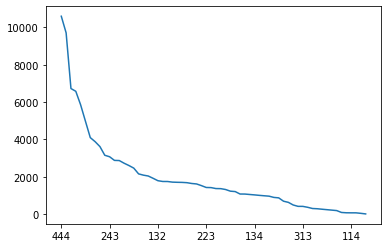

In [43]:
rfm['RFMClass'].value_counts().plot()


In [44]:
sns.set()

<AxesSubplot:xlabel='CustomerCode'>

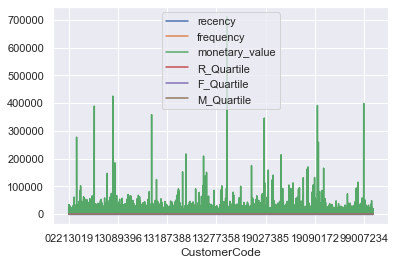

In [45]:
rfm.plot()

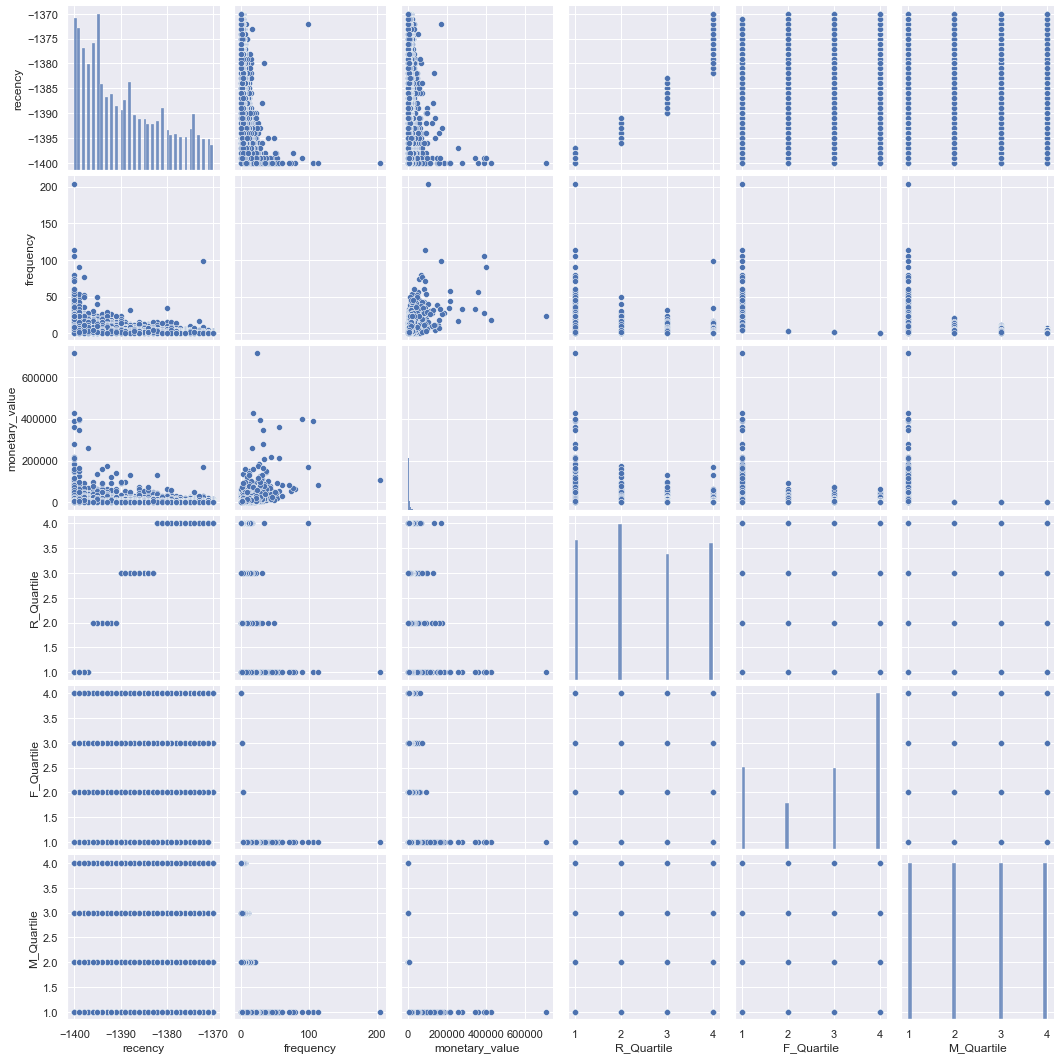

In [46]:
sns.pairplot(rfm)

<BarContainer object of 4 artists>

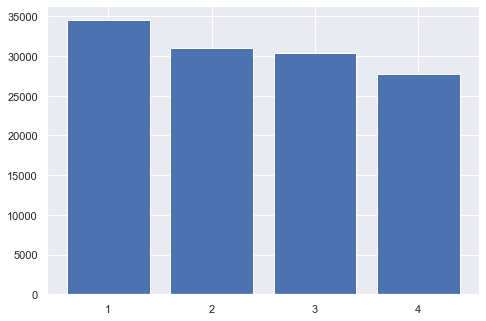

In [47]:
fig = plt.figure()
axes1 = fig.add_axes([0,0,1,1])

axes1.bar(x=['1','2','3','4'],height = rfm['R_Quartile'].value_counts())


<BarContainer object of 4 artists>

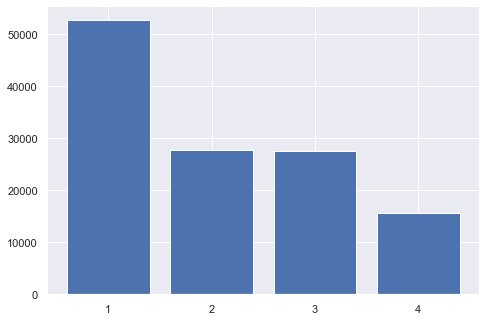

In [48]:
fig = plt.figure()
axes1 = fig.add_axes([0,0,1,1])

axes1.bar(x=['1','2','3','4'],height = rfm['F_Quartile'].value_counts())

<BarContainer object of 4 artists>

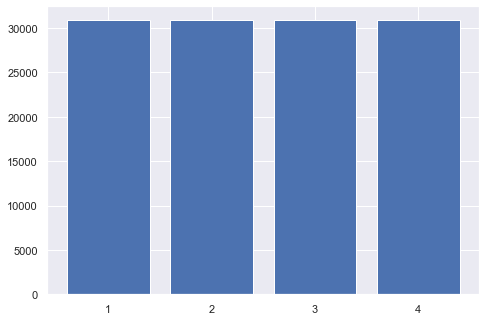

In [49]:
fig = plt.figure()
axes1 = fig.add_axes([0,0,1,1])

axes1.bar(x=['1','2','3','4'],height = rfm['M_Quartile'].value_counts())

<BarContainer object of 4 artists>

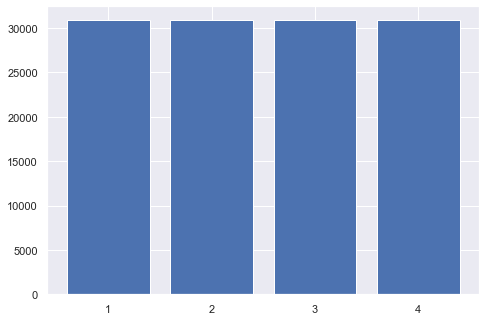

In [50]:
fig = plt.figure()
axes2 = fig.add_axes([0, 0, 1, 1])

axes2.bar(x=['1','2','3','4'],height = rfm['M_Quartile'].value_counts())

(array([2.7210e+03, 4.0800e+02, 2.8640e+03, 6.5780e+03, 2.5970e+03,
        1.0603e+04, 6.7260e+03, 2.8730e+03, 3.6120e+03, 1.3620e+03,
        1.3570e+03, 2.0810e+03, 9.7120e+03, 1.6770e+03, 1.5200e+03,
        4.9720e+03, 3.8770e+03, 2.9200e+02, 1.7420e+03, 3.1480e+03,
        1.7830e+03, 4.0940e+03, 1.7070e+03, 1.7400e+03, 1.2220e+03,
        5.8530e+03, 1.4200e+03, 2.0350e+03, 1.0690e+03, 1.6090e+03,
        1.0440e+03, 2.4580e+03, 9.9700e+02, 1.6340e+03, 1.2000e+03,
        1.9120e+03, 1.6920e+03, 1.0220e+03, 2.1490e+03, 6.2200e+02,
        1.4130e+03, 9.5400e+02, 1.3110e+03, 3.0680e+03, 3.5700e+02,
        1.0670e+03, 1.6980e+03, 6.8400e+02, 2.5300e+02, 9.7500e+02,
        2.0500e+02, 4.8100e+02, 8.8700e+02, 8.6300e+02, 2.7900e+02,
        2.2900e+02, 8.0000e+01, 4.0600e+02, 6.3000e+01, 1.8100e+02,
        6.0000e+01, 6.0000e+01, 3.3000e+01, 2.0000e+00]),
 array([ 0.      ,  0.984375,  1.96875 ,  2.953125,  3.9375  ,  4.921875,
         5.90625 ,  6.890625,  7.875   ,  8.859375, 

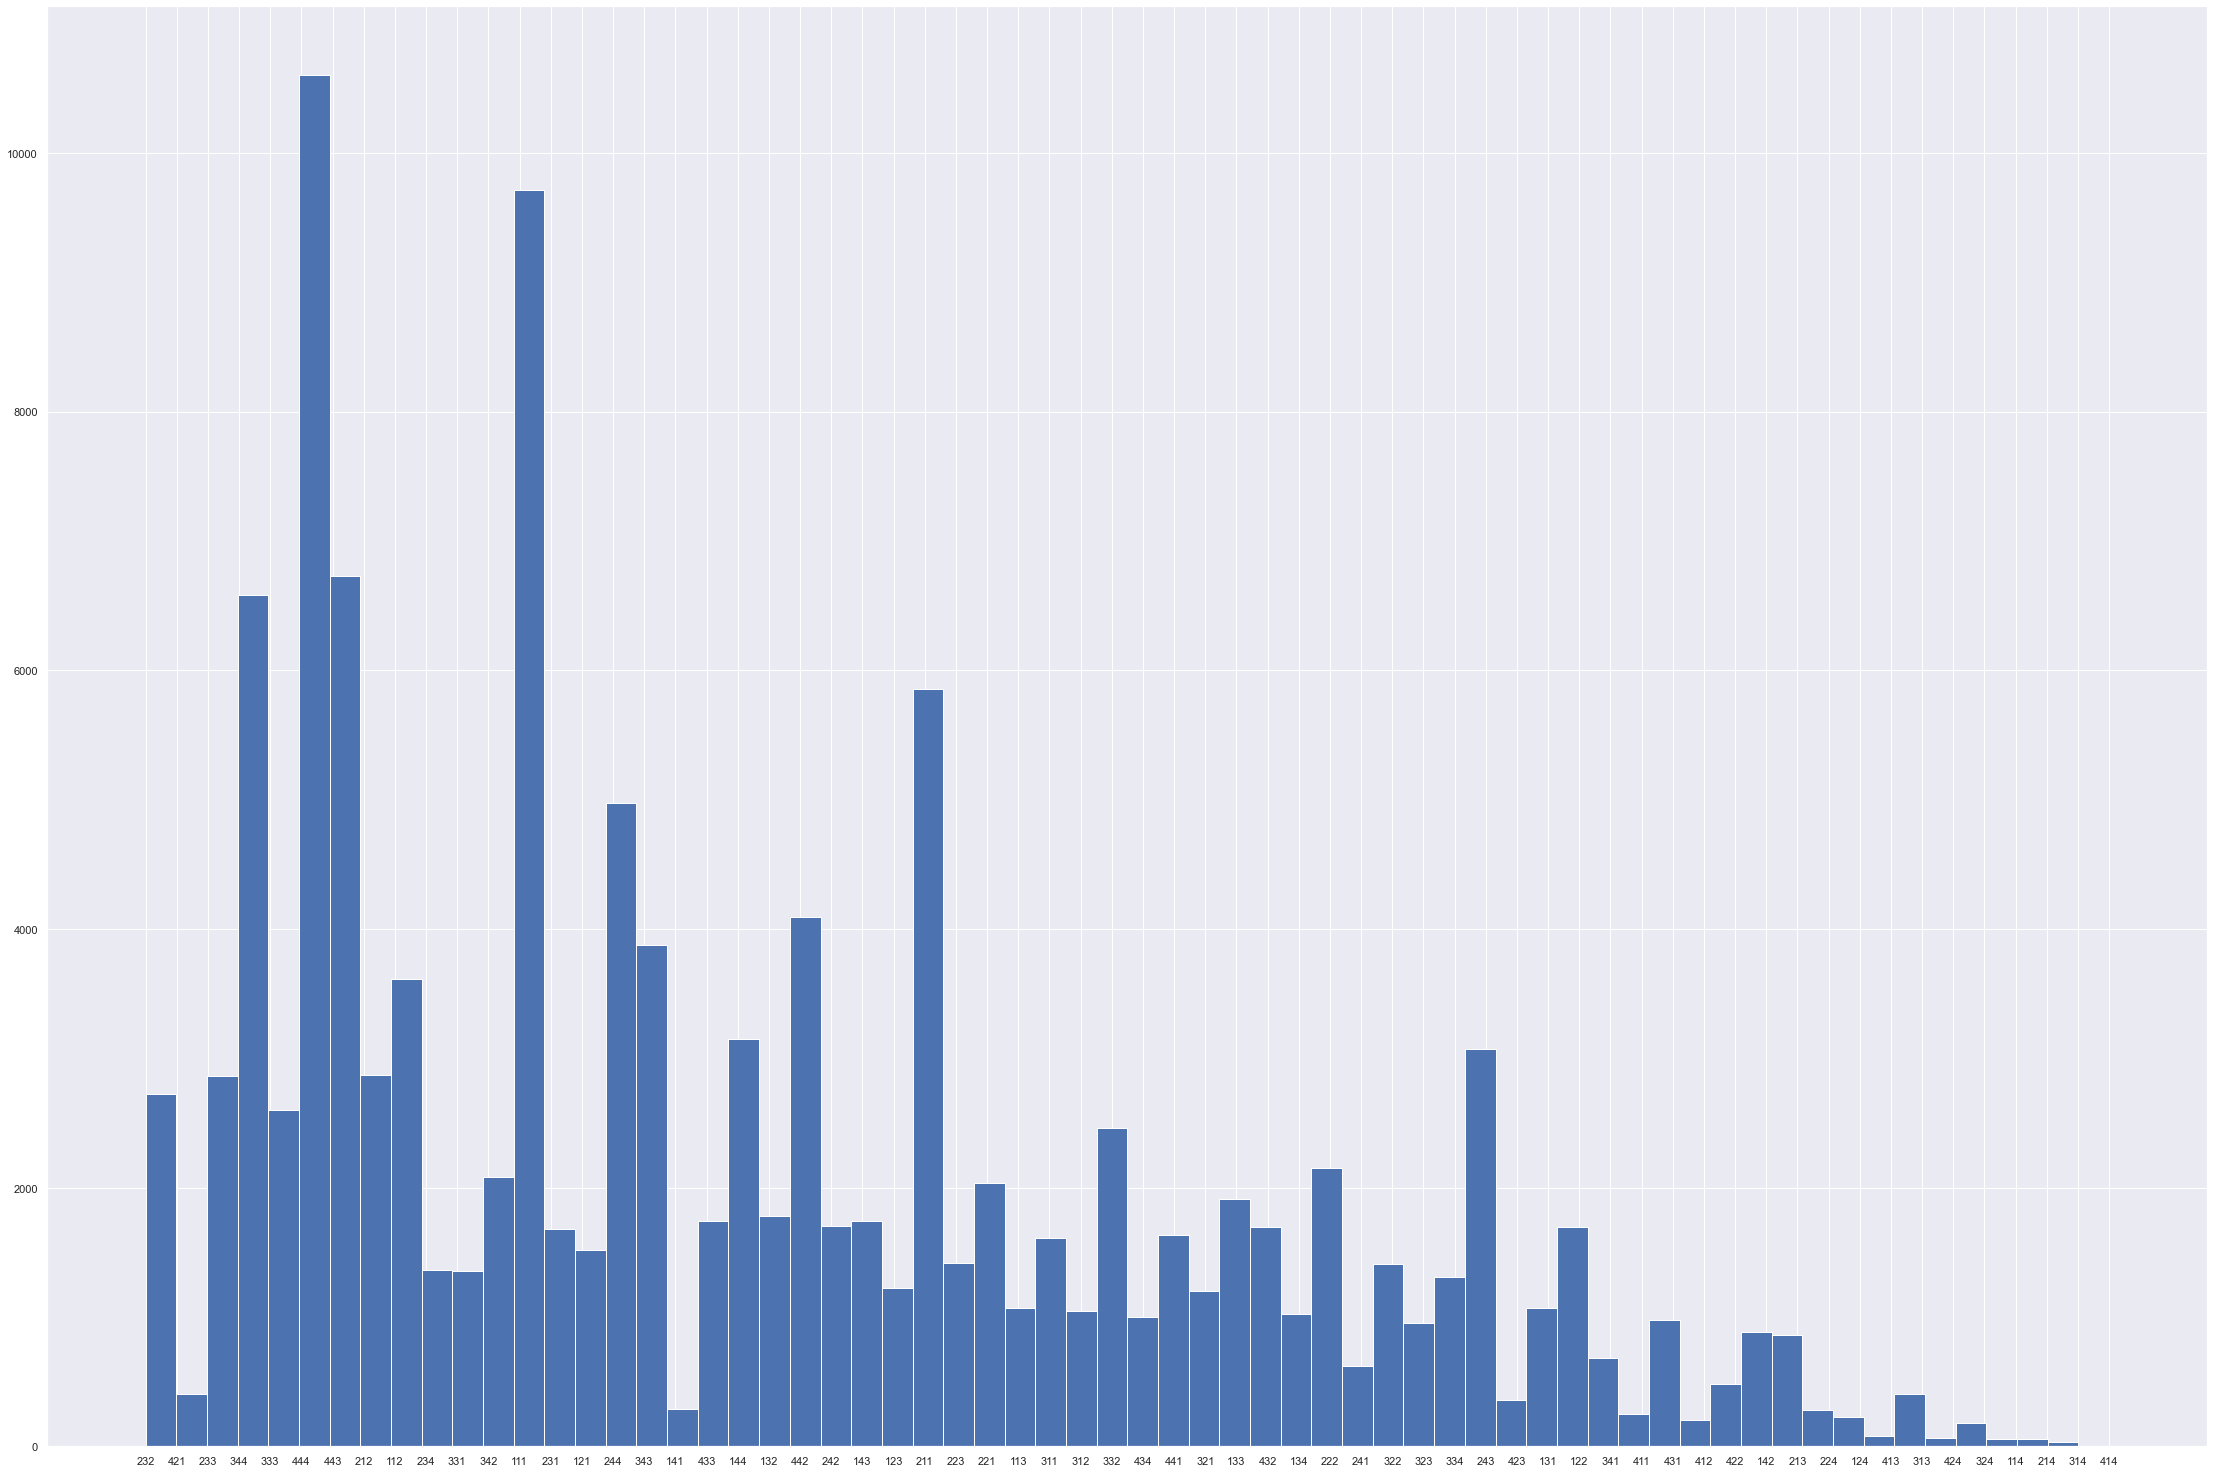

In [51]:
fig = plt.figure()
axes = fig.add_axes([0,0,5,5])
axes.hist(rfm['RFMClass'],bins = 64)

Text(0, 0.5, 'recency')

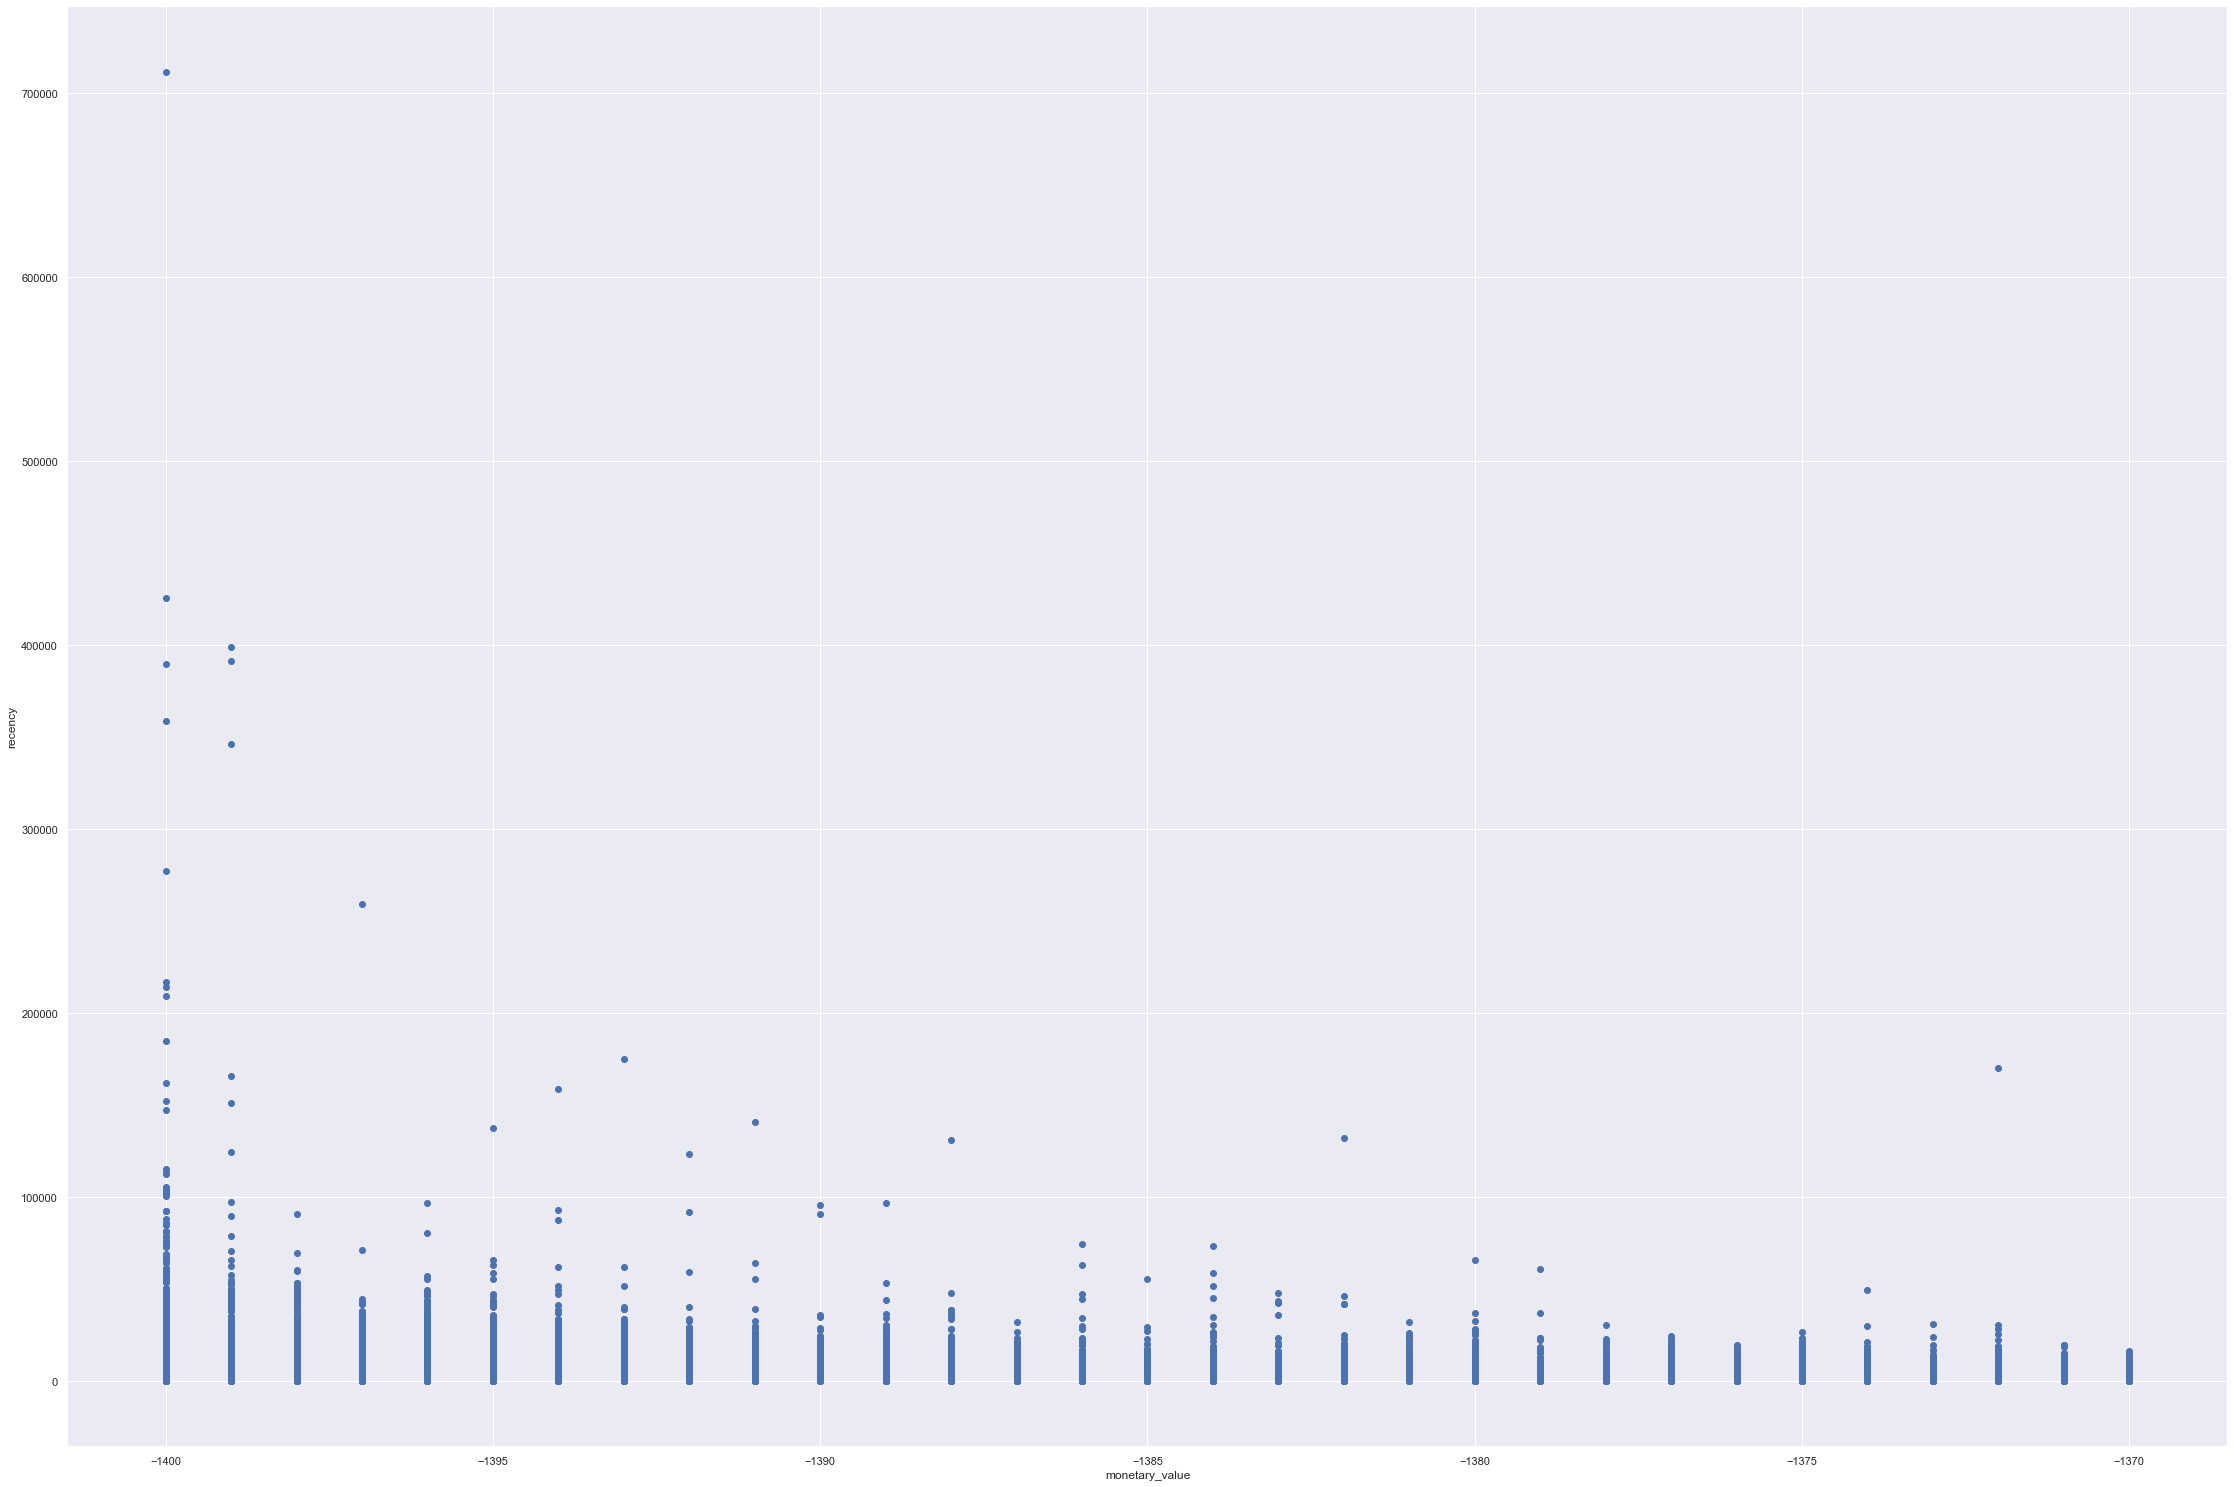

In [52]:
fig = plt.figure()
axes = fig.add_axes([0,0,5,5])
axes.scatter(x = rfm['recency'],y = rfm['monetary_value'])
axes.set_xlabel('monetary_value')
axes.set_ylabel('recency')

In [53]:
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode,plot, iplot

In [54]:
init_notebook_mode(connected = True)
cf.go_offline()

In [55]:
#rfm.iplot(kind  = 'scatter', x = 'recency', y = 'monetary_value', mode = 'markers')